In [ ]:
import pandas as pd

# Loading the dataset
df_tree = pd.read_csv("forestCover.csv")
print(df_tree.shape)
df_tree.head()


(581012, 59)


,Elevation,Aspect,Facet,Slope,Inclination,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Water_Level,Observation_ID,Cover_Type
0,3208920,166,415.394727,6,0.691628,408,62,3137,225,242,...,0,0,0,0,0,0,0,2,1,2
1,2789020,137,343.302186,9,0.621245,30,2,1040,235,237,...,0,0,0,0,0,0,0,3,1,3
2,3384615,357,894.231390,9,-0.266086,362,15,3113,207,225,...,0,0,0,0,0,0,0,4,1,1
3,3348150,148,371.346939,6,0.786375,247,50,1207,228,240,...,0,0,0,0,0,0,0,5,1,2
4,3061955,124,310.783430,11,-0.335685,170,19,1595,238,232,...,0,0,0,0,0,0,0,6,1,2


In [ ]:
# Dropping both Observation_ID (identifier) and Water_Level (constant)
df_tree.drop(columns=['Observation_ID', 'Water_Level'], inplace=True)


In [ ]:
# Facet is highly correlated with Aspect so dropping it
df_tree.drop(columns=['Facet'], inplace=True)


In [ ]:
# Inclination contains only noisy values, so dropping
df_tree.drop(columns=['Inclination'], inplace=True)


In [ ]:
# fixing soil type issue 
df_tree['Soil_Type1'] = df_tree['Soil_Type1'].map({'positive': 1, 'negative': 0}).astype(int)


In [ ]:
# fixing missing values issue
df_tree = df_tree.replace('?', pd.NA)
df_tree = df_tree.apply(pd.to_numeric, errors='ignore')

# Imputing missing values in Slope with median
df_tree['Slope'] = df_tree['Slope'].fillna(df_tree['Slope'].median())


/tmp/ipykernel_3891/305979018.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_tree = df_tree.apply(pd.to_numeric, errors='ignore')


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 20% of training data 
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Baseline DT evaluation on {X_train_sample.shape[0]} samples")

# the baseline Decision Tree model (class weight addresses skewed imbalance issue)
dt_baseline = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Stratified 5-fold CV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt_baseline, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')

print(f"Baseline Decision Tree Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Baseline DT evaluation on 92962 samples
Baseline Decision Tree Accuracy: 0.8513 ± 0.0022


Full training: 464809 samples
Sampled training: 92962 samples
Test set: 116203 samples
Running Decision Tree Grid Search with 5-fold CV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=

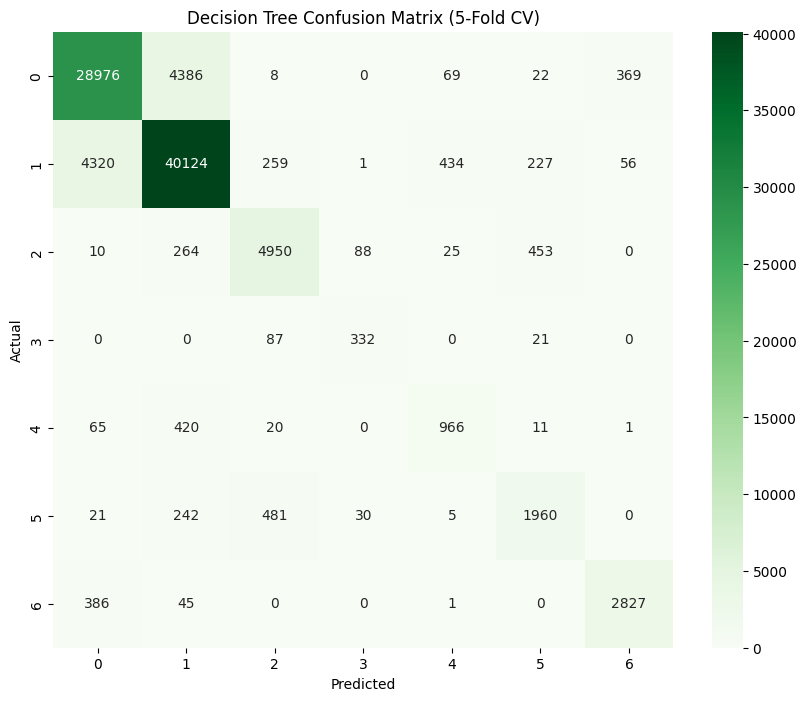


Confusion Matrix:
[[28976  4386     8     0    69    22   369]
 [ 4320 40124   259     1   434   227    56]
 [   10   264  4950    88    25   453     0]
 [    0     0    87   332     0    21     0]
 [   65   420    20     0   966    11     1]
 [   21   242   481    30     5  1960     0]
 [  386    45     0     0     1     0  2827]]

Held-out Test Set Accuracy: 0.8741


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# hyperparameter tuning model
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 20% of training data
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Full training: {X_train.shape[0]} samples")
print(f"Sampled training: {X_train_sample.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# the parameter grid for Decision Tree
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

# Grid search on sampled training data
print("Running Decision Tree Grid Search with 5-fold CV...")
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_sample, y_train_sample)
print("Best Params:", grid_search.best_params_)

# Getting training and test scores
best_index = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_index]
test_score = grid_search.best_score_

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy (CV): {test_score:.4f}")

# Getting the best model
best_dt = grid_search.best_estimator_

# Cross-validation scores with mean and std
cv_scores = cross_val_score(best_dt, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')
print(f"\n5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# F1 scores
f1_scores = cross_val_score(best_dt, X_train_sample, y_train_sample, cv=cv, scoring='f1_macro')
print(f"5-Fold CV F1-Macro: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# Getting the predictions for confusion matrix
y_pred_cv = cross_val_predict(best_dt, X_train_sample, y_train_sample, cv=cv)

# Detailed results
print("\nClassification Report (5-fold CV):")
print(classification_report(y_train_sample, y_pred_cv))

macro_f1 = f1_score(y_train_sample, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_train_sample, y_pred_cv, average='weighted')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_train_sample, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix (5-Fold CV)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nConfusion Matrix:")
print(cm)

# Testing on held-out test set
test_pred = best_dt.predict(X_test)
test_accuracy = best_dt.score(X_test, y_test)
print(f"\nHeld-out Test Set Accuracy: {test_accuracy:.4f}")